# Experiment design walkdown 

Can we modify the simulation to create an experiment that we can actually test? How many samples will we need in order to do so?

Todo:

- [ ] Walk down to continuous time (instead of discrete time)

In [2]:
%pylab inline
import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


# Baseline Model for experiment outcomes

This is the straight-up simulation code

In [21]:
def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False  # no path exists between the nodes


def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt


def measure(g, beliefs):
    """Take measurements of the state of the system (for creating figures)"""
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    # Fig 5A: similarity btw 5% and 95% most similar pairs
    # ----------------------------------------------------
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step
    ts = [0]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        m.append(measure(g, beliefs))  # ignore returned init suscep and adopt
        ts.append(step+1)
        
    df = pd.DataFrame(m, index=ts)
    return df

def random_connected_graph(n_agents=40, deg=3):
    # create a random connected social network g
    connected = False
    while not connected:
        g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
        connected = nx.is_connected(g)

    return g

def run(g0, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------
    beliefs = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values= beliefs
    )

    # Interdependent simulation
    # -------------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Independent simulation
    # ----------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions

    # calculate the population likelihood of being susceptible to a given (non-held) belief
    p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
         (1 - res1.loc[0, '% adopted']))

    # choose a set of beliefs for each agent to be susceptible to
    new_sus = {}
    for agent in g2:
        gc = nx.complete_graph(n_concepts)  # potentially susceptible to any belief
        gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
        # from remainder, randomly select a subset of beliefs to be susceptible to
        edges = list(itertools.compress(
            list(gc.edges()),  # selection candidates
            np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
        ))
        edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
        new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

    nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [11]:
def drawfigs(runs, 
             measures=['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)'],
             n_samples=30):
    
    plt.figure(figsize=(6,9))
    
    ax1 = plt.subplot(2,1,1)
    plt.hist(runs[measures[0]] - runs[measures[1]], bins=20);
    plt.vlines((runs[measures[0]] - runs[measures[1]]).mean(),0,10, 'r')
    plt.xlabel('Difference')
    plt.ylabel('Number of runs')
    plt.title("%s vs. %s"%(measures[0], measures[1]))
    
    ax2 = plt.subplot(2,1,2)
    n_runs = len(runs)
    res = {}
    for n_reps in range(2,n_samples):  # sample sizes to try
        p_vals = []
        for i in range(100): # number of times to try each sample size
            # 'conduct' experiment
            sample = runs.iloc[np.random.randint(n_runs, size=n_reps)]
            p_vals.append(stats.ttest_rel(sample[measures[0]], sample[measures[1]])[1])
        res[n_reps] = p_vals

    resdf = pd.DataFrame(res)

    resdf.unstack().droplevel(1).plot(linewidth=0, marker='+', alpha=.4, ax=ax2)
    resdf.mean().plot(linewidth=1, color='b', ax=ax2)
    plt.ylabel('P Value')
    plt.xticks(range(2,n_samples))
    plt.xlabel('Number of sample pairs')
    plt.box(False)

    ax3 = ax2.twinx()
    ax3.plot(resdf.columns, (resdf < .05).mean()*100, 'r')
    plt.ylabel('% Experiments with p<.05', color='r')
    plt.box(False)



# Run experiment on baseline

This is the model and parameters that the theory was developed on. If the real world behaved exactly like this simplified representation, how many samples would we need in the experiment?

In [76]:
n_runs = 50
runs0 = pd.concat([run(random_connected_graph(n_agents=60, deg=3), t_match_susceptibility=10).iloc[-1] 
                  for _ in range(n_runs)], axis=1).T
    

In [154]:
runs0.head()

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
1,0.620000,0.511389,0.314081,-0.158929,13.298744,0.625111,0.501944,0.211184,-0.057159,6.840987
1,0.667944,0.576222,0.333026,-0.174491,11.689905,0.670833,0.564056,0.194723,-0.054657,6.662588
1,0.717336,0.647603,0.366430,-0.187124,12.610715,0.717001,0.622520,0.184667,-0.058893,8.441364
1,0.679405,0.592368,0.323485,-0.161745,11.095896,0.681201,0.592929,0.171464,-0.070523,5.318471
1,0.690833,0.593778,0.325304,-0.184732,10.236877,0.692000,0.602833,0.170368,-0.073788,6.627864


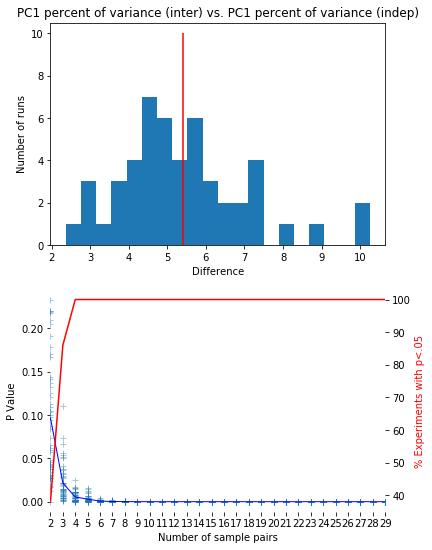

In [77]:
drawfigs(runs0)

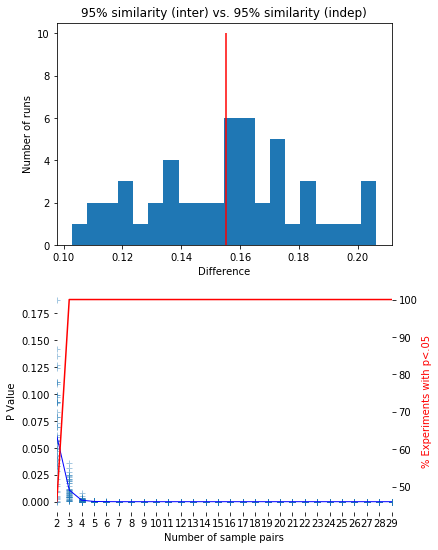

In [78]:
drawfigs(runs0, measures=['95% similarity (inter)', '95% similarity (indep)'])

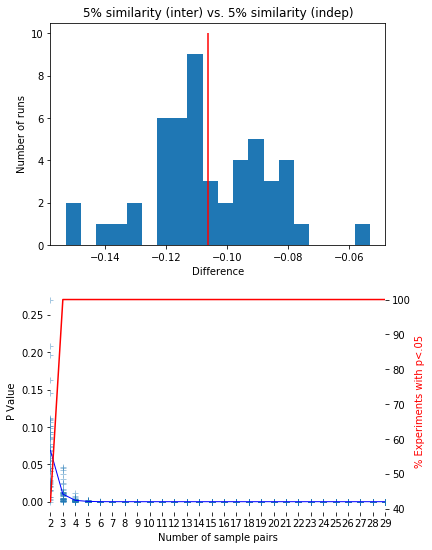

In [79]:
drawfigs(runs0, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [80]:
! say "part 1 complete"

# experiment parameters

If humans behaved exactly like the simulated agents, but we set the parameters to something easier to experiment with, how many samples would be needed?

In [22]:
runs1 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=13, # give enough starting beliefs that the triangle closing rule works
        t_match_susceptibility=10,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

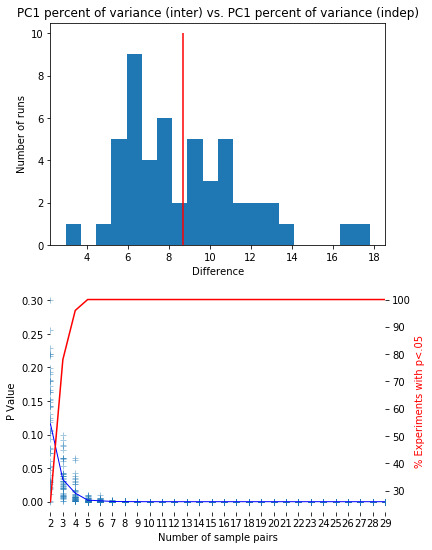

In [83]:
drawfigs(runs1)

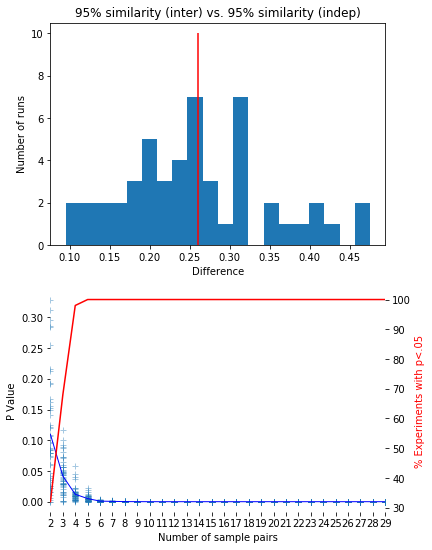

In [84]:
drawfigs(runs1, measures=['95% similarity (inter)', '95% similarity (indep)'])

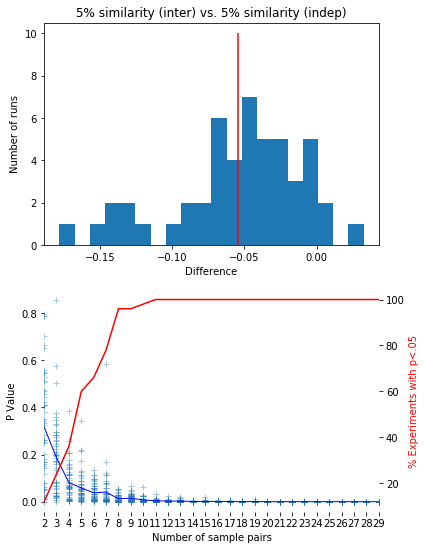

In [85]:
drawfigs(runs1, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [23]:
edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]

n_runs = 50
runs1c = pd.concat([
    run(nx.from_edgelist(edgelist), 
        n_concepts=13,
        n_beliefs=13, # give enough starting beliefs that the triangle closing rule works
        t_match_susceptibility=10,
       ).iloc[-1]
    for _ in range(n_runs)], 
    axis=1).T



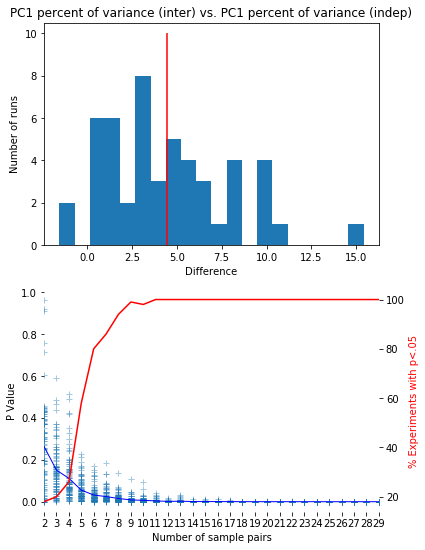

In [24]:
drawfigs(runs1c)

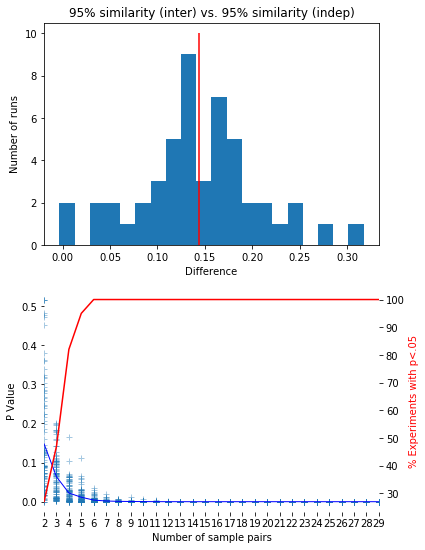

In [26]:
drawfigs(runs1c, measures=['95% similarity (inter)', '95% similarity (indep)'])

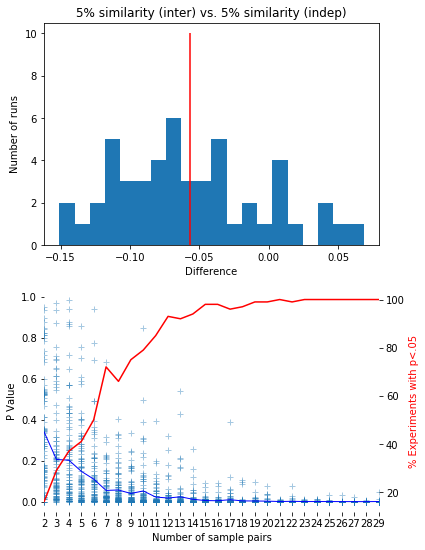

In [27]:
drawfigs(runs1c, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [28]:
pd.merge(runs1c

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
10,0.739103,0.610897,0.616008,-0.170203,21.524409,0.744872,0.619231,0.518128,-0.107307,18.553438
10,0.749342,0.662500,0.508008,-0.194702,19.612442,0.744079,0.656579,0.389510,-0.111430,16.395364
10,0.782667,0.664000,0.622274,-0.117347,24.013459,0.788667,0.696667,0.450844,-0.085203,18.957330
10,0.720779,0.600000,0.569389,-0.264772,28.483266,0.700649,0.577922,0.445487,-0.131691,17.503303
10,0.761538,0.673718,0.600675,-0.165300,17.862170,0.765385,0.654487,0.444517,-0.128483,16.856432
10,0.681818,0.577922,0.557846,-0.212935,22.128822,0.694156,0.556494,0.436188,-0.106019,18.671200
10,0.809459,0.727027,0.614940,-0.089844,24.015573,0.810811,0.715541,0.489007,-0.144675,20.901433
10,0.769079,0.654605,0.587563,-0.199331,27.200581,0.776316,0.696053,0.392038,-0.134494,17.391629
10,0.731818,0.633766,0.615946,-0.185766,22.862058,0.738961,0.615584,0.451243,-0.099618,17.154078
10,0.783333,0.676923,0.591505,-0.170187,25.206117,0.775641,0.678205,0.479058,-0.152767,18.702594


In [86]:
! say "part 2 complete"

# experiment measures
In the experiment we are only taking measures on 'spoke' beliefs, which cuts down the resolution still further. How many samples do we need to get a result with this modification?

In [87]:
# redefine the 'measure' function
def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted

In [88]:
runs2 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=13, # give enough starting beliefs that the triangle closing rule works
        t_match_susceptibility=1,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

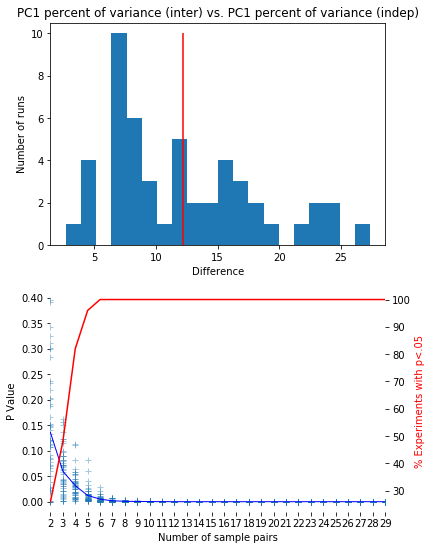

In [89]:
drawfigs(runs2)

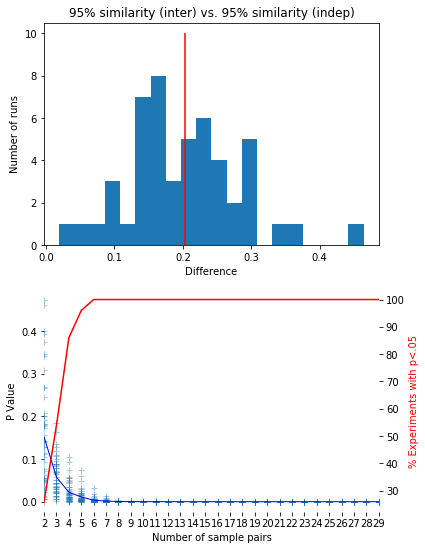

In [90]:
drawfigs(runs2, measures=['95% similarity (inter)', '95% similarity (indep)'])

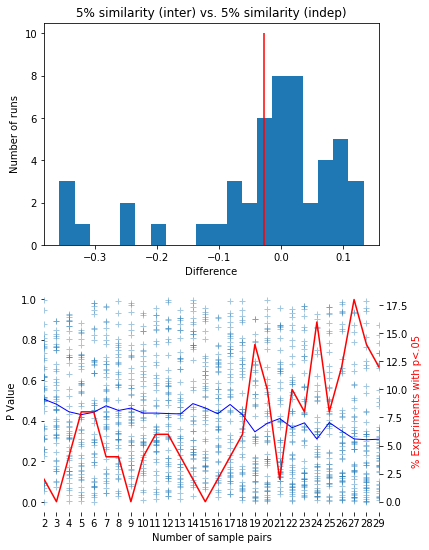

In [93]:
drawfigs(runs2, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [92]:
! say "part 3 complete"

# stochastic behavior rule

This isn't an actual decision rule, it's just a plausible alternative that accounts for a base rate and familiarity

This compares a plausible outcome of the treatment case with the idealized control case. If this shows an effect, but the next doesn't it means that our control case is not good enough.

In [94]:
def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt

In [95]:
n_runs=50
runs3 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=4, # give enough starting beliefs that the triangle closing rule works
        t_match_susceptibility=1,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

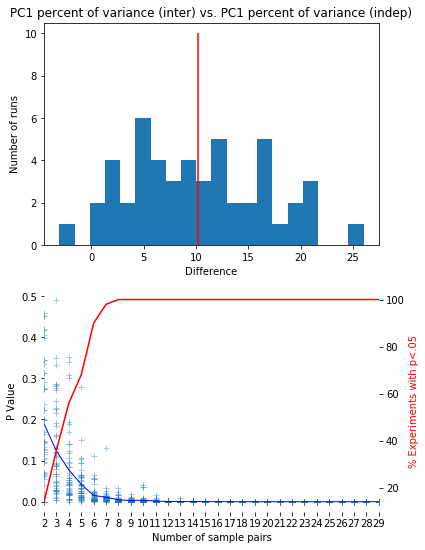

In [96]:
drawfigs(runs3)

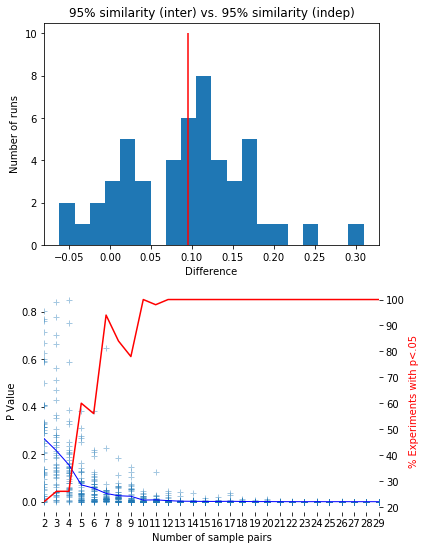

In [97]:
drawfigs(runs3, measures=['95% similarity (inter)', '95% similarity (indep)'])

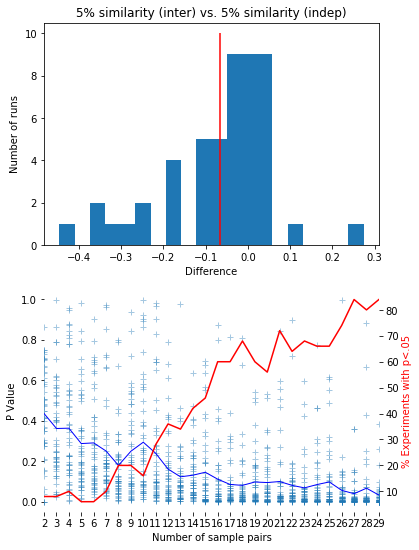

In [98]:
drawfigs(runs3, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [99]:
! say "Part 4 complete"

# Experiment Manipulation
In the actual experiment, we can't force independence. 

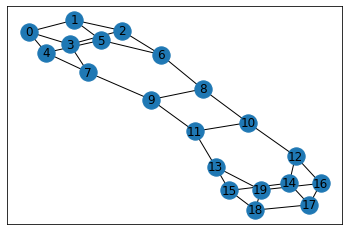

In [49]:
edgelist = [(0,1), (1,2), (2,3), (3,0),
            (0,4), (1,5), (2,6), (3,7),
            (4,5), (5,6), (4,7),
            (6,8), (7,9), (8,9),
            (8,10), (9,11), (10,11),
            (10,12), (11,13),
            (12,14), (14,15), (15,13),
            (12,16), (14,17), (15,18), (13,19),
            (16,19), (16,17), (17,18), (18,19)
]
g0c = nx.from_edgelist(edgelist)
nx.draw_networkx(g0c)

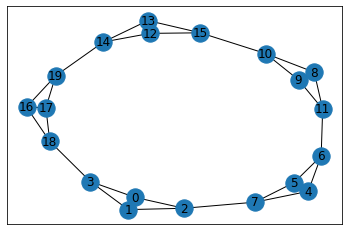

In [45]:
edgelist = [(0,1), (0,2), (0,3),
        (1,2), (1,3),
        (2,7),
        (4,5), (4,6), (4,7),
        (5,6), (5,7),
        (6,11),
        (8,9), (8,10), (8,11),
        (9,10), (9,11),
        (10,15),
        (12,13), (12,14), (12,15),
        (13,14), (13,15),
        (14,19),
        (16,17), (16,18), (16,19),
        (17,18), (17,19),
        (18,3)]
g0c = nx.from_edgelist(edgelist)
nx.draw_networkx(g0c)

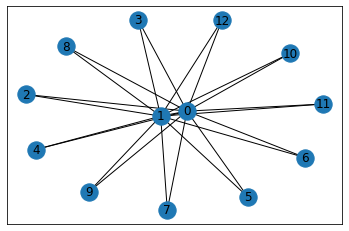

In [3]:
core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

i = 13
control_edges = copy.deepcopy(core_edges)
for n in range (2, 13):
    for s in range(5):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
#nx.draw_networkx(control_beliefs)
nx.draw_networkx(core_network)

def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt
        
def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt        

def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step
    ts = [0]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        m.append(measure(g, beliefs))  # ignore returned init suscep and adopt
        ts.append(step+1)
        
    df = pd.DataFrame(m, index=ts)
    return df


def measure(g, beliefs):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
               (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100
    
    # need to repeat and take averages, or we're just comparing to a different noisy signal
    e95 = []
    e5 = []
    ePC1 = []
    for _ in range(100):
        shuffle_adopt = pd.DataFrame()
        for col in adopt.columns:
            shuffle_adopt[col] = np.random.permutation(adopt[col].values)

        n_agents = len(shuffle_adopt.index)
        corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        e95.append(np.percentile(corrs, 95))
        e5.append(np.percentile(corrs, 5))

        pca = PCA(n_components=1)
        pca.fit(shuffle_adopt)
        ePC1.append(pca.explained_variance_ratio_[0] * 100)
        
    res['expected PC1 percent of variance'] = np.mean(ePC1)
    res['expected 95% similarity'] = np.mean(e95)
    res['expected 5% similarity'] = np.mean(e5)
    
    res['net expected PC1 percent of variance'] = res['PC1 percent of variance'] - res['expected PC1 percent of variance']
    res['net 95% similarity'] = res['95% similarity'] - res['expected 95% similarity']  
    res['net 5% similarity'] = res['5% similarity'] - res['expected 5% similarity']  
    return res

def run(n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """
    g0 = nx.dodecahedral_graph()
    
# Connected Caveman
#     edgelist = [(0,1), (0,2), (0,3),
#             (1,2), (1,3),
#             (2,7),
#             (4,5), (4,6), (4,7),
#             (5,6), (5,7),
#             (6,11),
#             (8,9), (8,10), (8,11),
#             (9,10), (9,11),
#             (10,15),
#             (12,13), (12,14), (12,15),
#             (13,14), (13,15),
#             (14,19),
#             (16,17), (16,18), (16,19),
#             (17,18), (17,19),
#             (18,3)]

    # cube/ladder
    edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0c = nx.from_edgelist(edgelist)
    
    
    n_concepts=13
    n_beliefs=4
    beliefs = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # give agents their initial beliefs in dodec network
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values = beliefs
    )
    
    # give agents their initial beliefs in caveman network
    nx.set_node_attributes(
        g0c,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values = beliefs
    )

    ######### dodec network ########
    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2:
        new_edges = []
        for edge in g2.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation
    
    res = pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame
    
    ########## caveman network #########
    # Treatment simulation
    # --------------------
    g1c = copy.deepcopy(g0c)  # create copy, to preserve initial conditions for other case
    res1c = simulate(g1c, n_steps)

    # Control simulation
    # ------------------
    g2c = copy.deepcopy(g0c)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2c:
        new_edges = []
        for edge in g2c.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2c.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2c = simulate(g2c, n_steps)  # perform simulation
    
    resc = pd.merge(res1c, res2c, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    return pd.merge(res, resc, left_index=True, right_index=True,
                    suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame



# n_runs=250
# runs4 = pd.concat([
#     run().iloc[-1] 
#     for _ in range(n_runs)], 
#     axis=1).T



# runs4.dropna(inplace=True)
# n_runs=len(runs4)

# runs4.head()

In [5]:
n_steps = 10

g0 = nx.dodecahedral_graph()
    
# Connected Caveman
#     edgelist = [(0,1), (0,2), (0,3),
#             (1,2), (1,3),
#             (2,7),
#             (4,5), (4,6), (4,7),
#             (5,6), (5,7),
#             (6,11),
#             (8,9), (8,10), (8,11),
#             (9,10), (9,11),
#             (10,15),
#             (12,13), (12,14), (12,15),
#             (13,14), (13,15),
#             (14,19),
#             (16,17), (16,18), (16,19),
#             (17,18), (17,19),
#             (18,3)]

# cube/ladder
edgelist = [(0,1), (1,2), (2,3), (3,0),
            (0,4), (1,5), (2,6), (3,7),
            (4,5), (5,6), (4,7),
            (6,8), (7,9), (8,9),
            (8,10), (9,11), (10,11),
            (10,12), (11,13),
            (12,14), (14,15), (15,13),
            (12,16), (14,17), (15,18), (13,19),
            (16,19), (16,17), (17,18), (18,19)
]
g0c = nx.from_edgelist(edgelist)


n_concepts=13
n_beliefs=4
beliefs = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}

# give agents their initial beliefs in dodec network
nx.set_node_attributes(
    g0,
    name='M',  # set node attribute 'M' (for 'mind')
    # create a semantic network with a different random set of beliefs
    # for each agent, and assign to nodes in the social network
    values = beliefs
)

# give agents their initial beliefs in caveman network
nx.set_node_attributes(
    g0c,
    name='M',  # set node attribute 'M' (for 'mind')
    # create a semantic network with a different random set of beliefs
    # for each agent, and assign to nodes in the social network
    values = beliefs
)

######### dodec network ########
# Treatment simulation
# --------------------
g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
res1 = simulate(g1, n_steps)

# Control simulation
# ------------------
g2 = copy.deepcopy(g0)  # copy from original starting conditions
# give spoke and spur beliefs
for agent in g2:
    new_edges = []
    for edge in g2.nodes[agent]['M'].edges():
        if control_beliefs.has_edge(*edge):
            new_edges.append(edge)
        else:
            end = np.random.choice(edge)
            options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
            new_edges.append(options[np.random.randint(len(options))])

    g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)

res2 = simulate(g2, n_steps)  # perform simulation

res = pd.merge(res1, res2, left_index=True, right_index=True,
                suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

########## caveman network #########
# Treatment simulation
# --------------------
g1c = copy.deepcopy(g0c)  # create copy, to preserve initial conditions for other case
res1c = simulate(g1c, n_steps)

# Control simulation
# ------------------
g2c = copy.deepcopy(g0c)  # copy from original starting conditions
# give spoke and spur beliefs
for agent in g2c:
    new_edges = []
    for edge in g2c.nodes[agent]['M'].edges():
        if control_beliefs.has_edge(*edge):
            new_edges.append(edge)
        else:
            end = np.random.choice(edge)
            options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
            new_edges.append(options[np.random.randint(len(options))])

    g2c.nodes[agent]['M'] = nx.from_edgelist(new_edges)

res2c = simulate(g2c, n_steps)  # perform simulation

resc = pd.merge(res1c, res2c, left_index=True, right_index=True,
                suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

res = pd.merge(res, resc, left_index=True, right_index=True,
                    suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame



In [10]:
res.iloc[0]

% susceptible (inter) (dodec)                              0.122727
% adopted (inter) (dodec)                                  0.056818
95% similarity (inter) (dodec)                             0.690066
5% similarity (inter) (dodec)                             -0.125656
PC1 percent of variance (inter) (dodec)                   17.821437
expected PC1 percent of variance (inter) (dodec)          21.227345
expected 95% similarity (inter) (dodec)                    0.535074
expected 5% similarity (inter) (dodec)                    -0.127331
net expected PC1 percent of variance (inter) (dodec)      -3.405908
net 95% similarity (inter) (dodec)                         0.154991
net 5% similarity (inter) (dodec)                          0.001674
% susceptible (indep) (dodec)                              0.065909
% adopted (indep) (dodec)                                  0.056818
95% similarity (indep) (dodec)                             0.690066
5% similarity (indep) (dodec)                   

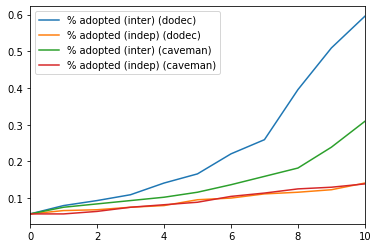

In [11]:
res[['% adopted (inter) (dodec)', '% adopted (indep) (dodec)', 
     '% adopted (inter) (caveman)', '% adopted (indep) (caveman)']].plot()

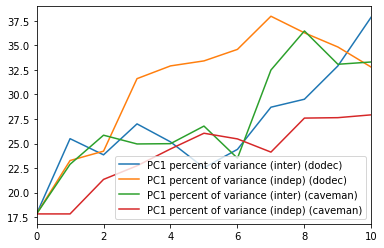

In [12]:
res[['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)', 
     'PC1 percent of variance (inter) (caveman)', 'PC1 percent of variance (indep) (caveman)']].plot()

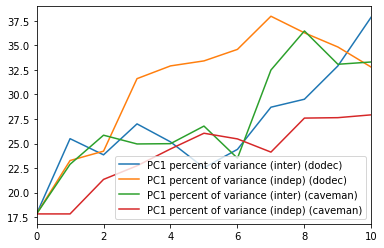

In [16]:
res[['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)', 
     'PC1 percent of variance (inter) (caveman)', 'PC1 percent of variance (indep) (caveman)']].plot()

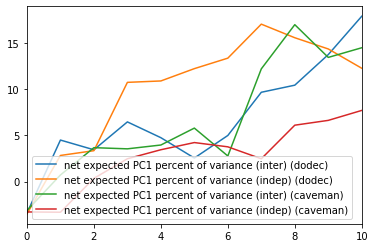

In [14]:
res[['net expected PC1 percent of variance (inter) (dodec)', 'net expected PC1 percent of variance (indep) (dodec)', 
     'net expected PC1 percent of variance (inter) (caveman)', 'net expected PC1 percent of variance (indep) (caveman)']].plot()

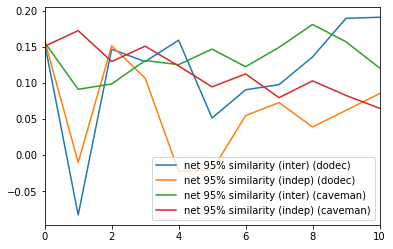

In [15]:

res[['net 95% similarity (inter) (dodec)', 'net 95% similarity (indep) (dodec)', 
     'net 95% similarity (inter) (caveman)', 'net 95% similarity (indep) (caveman)']].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a27895290>,
      dtype=object)

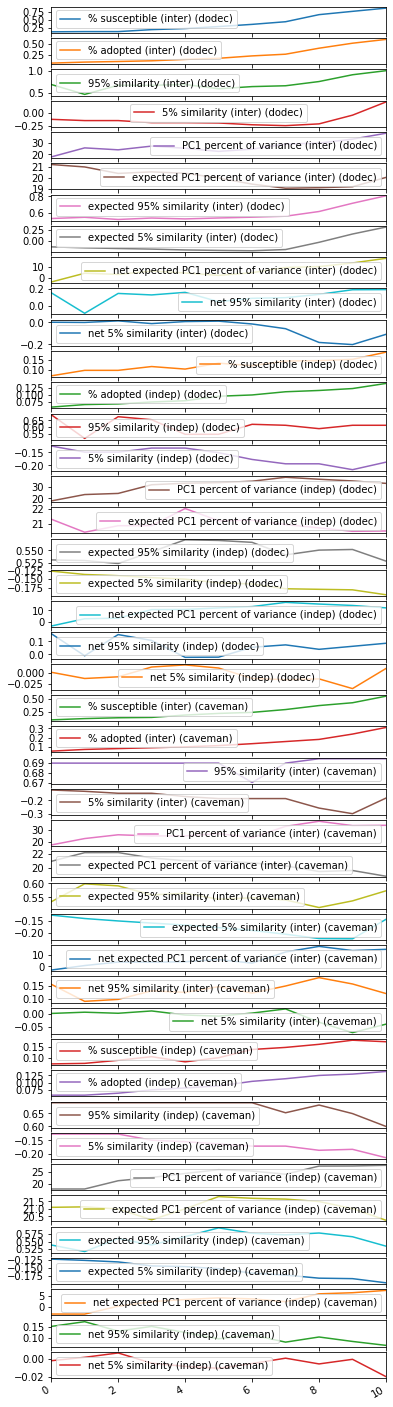

In [9]:
res.plot(subplots=True, figsize=(6,28));

In [51]:
runs4.mean()

% susceptible (inter) (dodec)                              0.463355
% adopted (inter) (dodec)                                  0.228482
95% similarity (inter) (dodec)                             0.749780
5% similarity (inter) (dodec)                             -0.172247
PC1 percent of variance (inter) (dodec)                   32.928331
expected PC1 percent of variance (inter) (dodec)          21.233532
expected 95% similarity (inter) (dodec)                    0.630389
expected 5% similarity (inter) (dodec)                    -0.118557
net expected PC1 percent of variance (inter) (dodec)      11.694799
net 95% similarity (inter) (dodec)                         0.119391
net 5% similarity (inter) (dodec)                         -0.053690
% susceptible (indep) (dodec)                              0.143482
% adopted (indep) (dodec)                                  0.107209
95% similarity (indep) (dodec)                             0.648290
5% similarity (indep) (dodec)                   

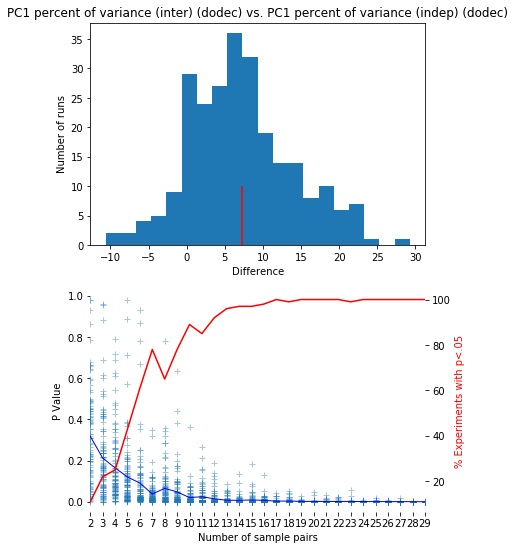

In [52]:
drawfigs(runs4, measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'])

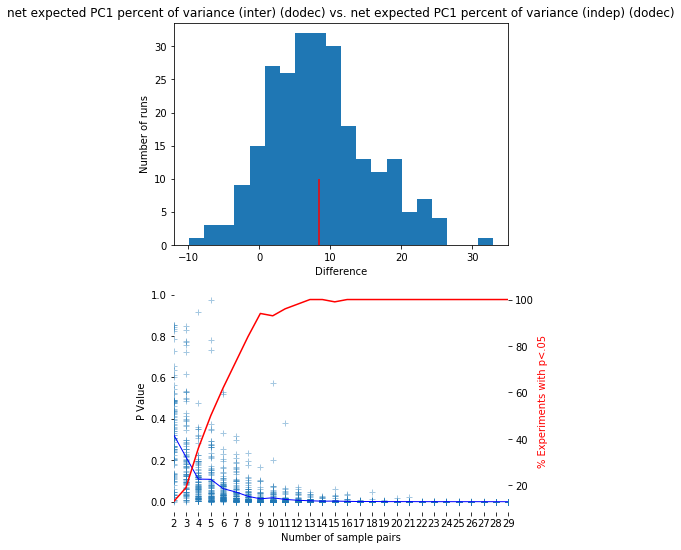

In [53]:
drawfigs(runs4, measures=['net expected PC1 percent of variance (inter) (dodec)', 'net expected PC1 percent of variance (indep) (dodec)'])

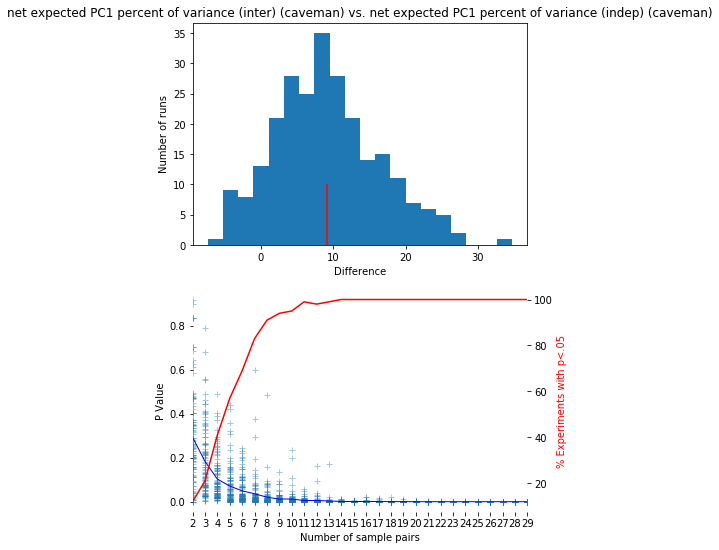

In [54]:
drawfigs(runs4, measures=['net expected PC1 percent of variance (inter) (caveman)', 'net expected PC1 percent of variance (indep) (caveman)'])

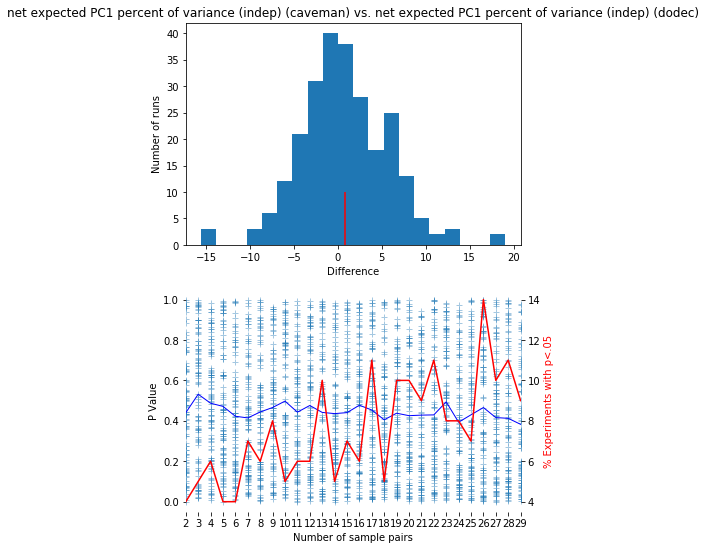

In [55]:
drawfigs(runs4, measures=['net expected PC1 percent of variance (indep) (caveman)', 'net expected PC1 percent of variance (indep) (dodec)'])

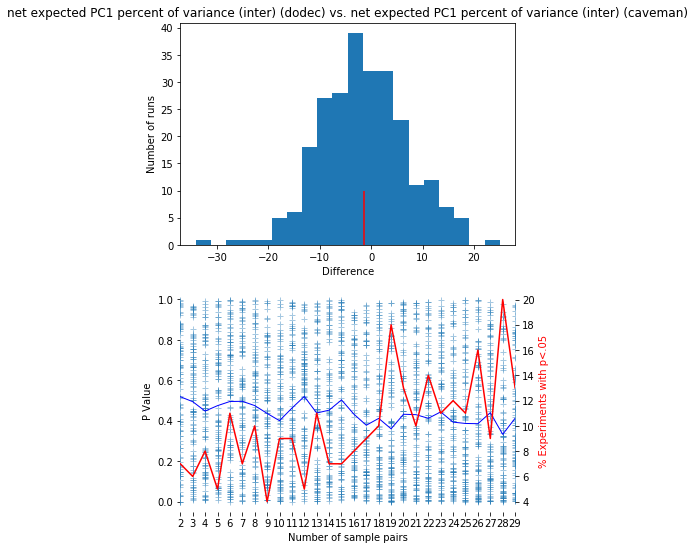

In [56]:
drawfigs(runs4, measures=['net expected PC1 percent of variance (inter) (dodec)', 'net expected PC1 percent of variance (inter) (caveman)'])

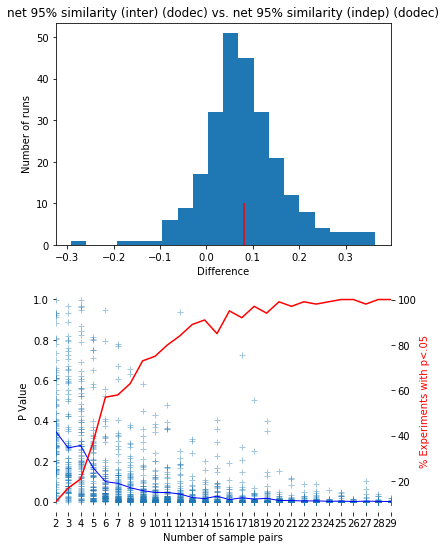

In [57]:
drawfigs(runs4, measures=['net 95% similarity (inter) (dodec)', 'net 95% similarity (indep) (dodec)'])

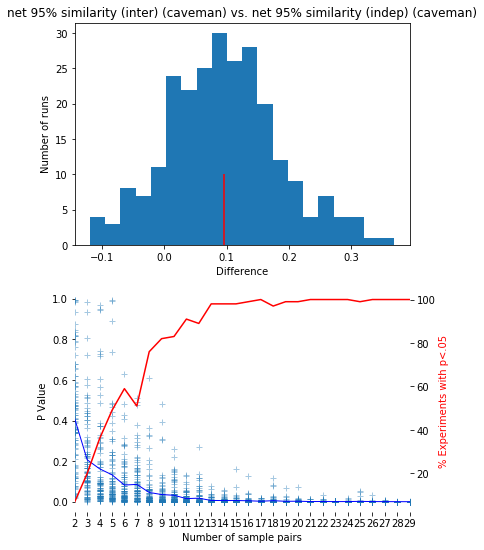

In [58]:
drawfigs(runs4, measures=['net 95% similarity (inter) (caveman)', 'net 95% similarity (indep) (caveman)'])

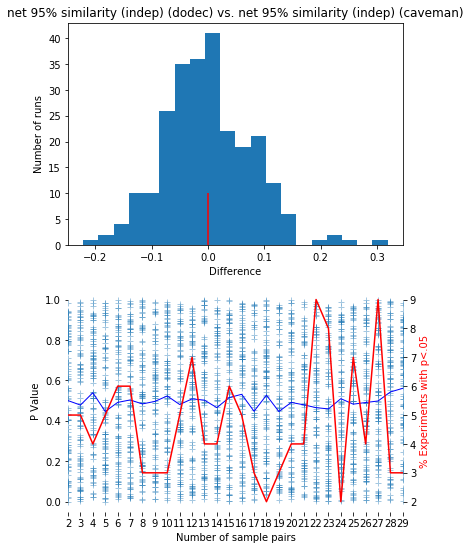

In [59]:
drawfigs(runs4, measures=['net 95% similarity (indep) (dodec)', 'net 95% similarity (indep) (caveman)'])

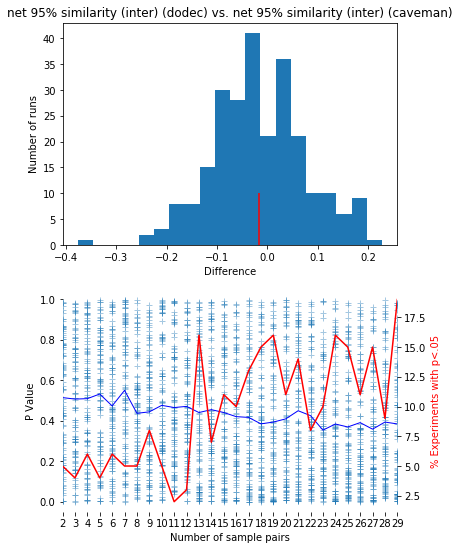

In [60]:
drawfigs(runs4, measures=['net 95% similarity (inter) (dodec)', 'net 95% similarity (inter) (caveman)'])

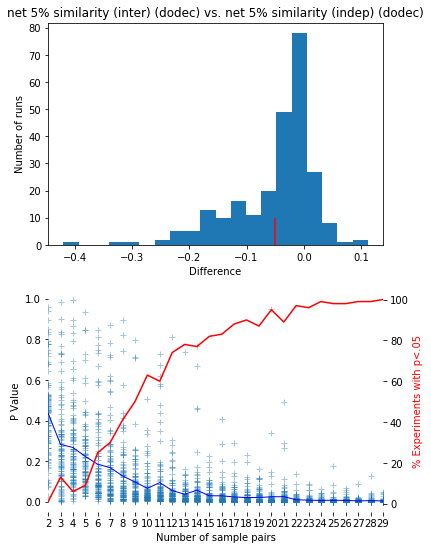

In [61]:
drawfigs(runs4, measures=['net 5% similarity (inter) (dodec)', 'net 5% similarity (indep) (dodec)'])

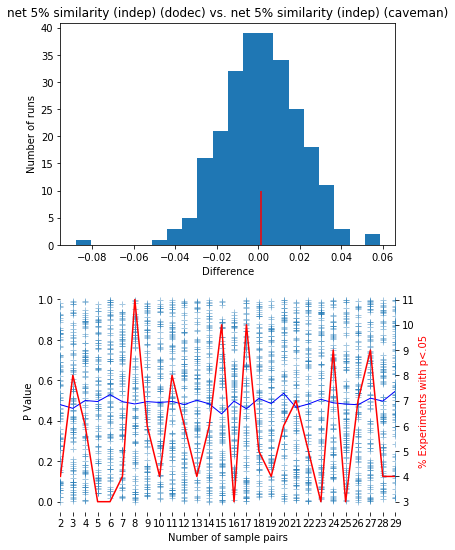

In [62]:
drawfigs(runs4, measures=['net 5% similarity (indep) (dodec)', 'net 5% similarity (indep) (caveman)'])

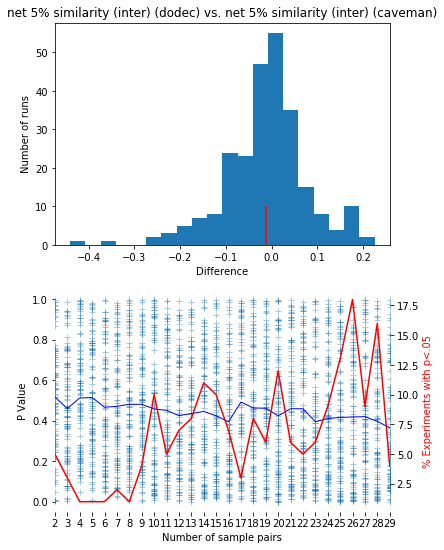

In [63]:
drawfigs(runs4, measures=['net 5% similarity (inter) (dodec)', 'net 5% similarity (inter) (caveman)'])

# Adjustments
If we wanted to change some things about the experiment to improve it's discriminative power, what could we do?

## 1. Ignore second core element

The fact that there are two different core elements means that in our measurements of spoke clues, there are clues taht are not truly independent of one another. We could adjust the measurement of the existing experiment to only look at the spokes attached to either the crime scene or the stolen object.

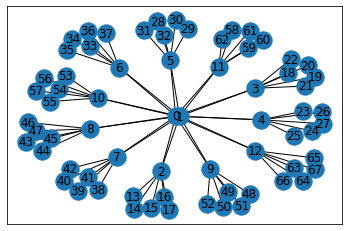

In [100]:
core_edges = [(0, 1), 
              (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
              (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

i = 13
control_edges = copy.deepcopy(core_edges)
for n in range (2, 13):
    for s in range(5):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
#nx.draw_networkx(core_network)


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt


def run(g0, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g0:
        new_edges = []
        for edge in g0.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame



###### This changes:
def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted

In [101]:
n_runs=50
runs5 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=4,
        t_match_susceptibility=1,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

runs5.head()

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
1,0.713636,0.572727,0.670820,-0.310530,32.601797,0.213636,0.186364,0.67082,-0.356348,36.576219
1,0.309091,0.172727,1.000000,-0.239046,45.109943,0.190909,0.131818,0.67082,-0.288675,41.372017
1,0.736364,0.377273,1.000000,0.288675,53.512661,0.186364,0.118182,0.76980,-0.222222,36.674164
1,0.259091,0.063636,1.000000,-0.149071,32.460888,0.100000,0.086364,1.00000,-0.222222,33.087975
1,0.513636,0.318182,0.690066,-0.356348,33.988181,0.209091,0.172727,0.67082,-0.288675,25.739163


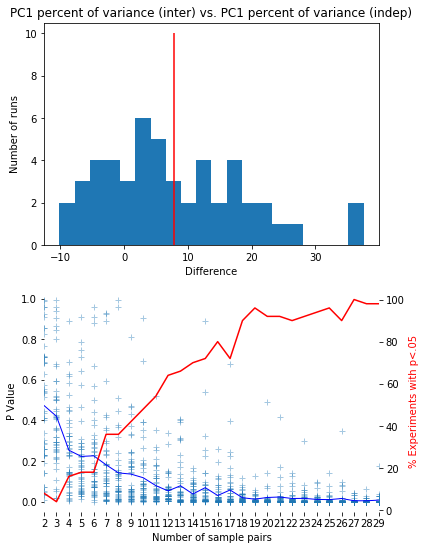

In [102]:
drawfigs(runs5)

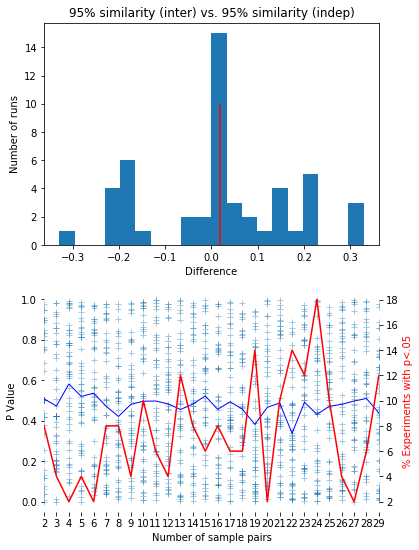

In [103]:
drawfigs(runs5, measures=['95% similarity (inter)', '95% similarity (indep)'])

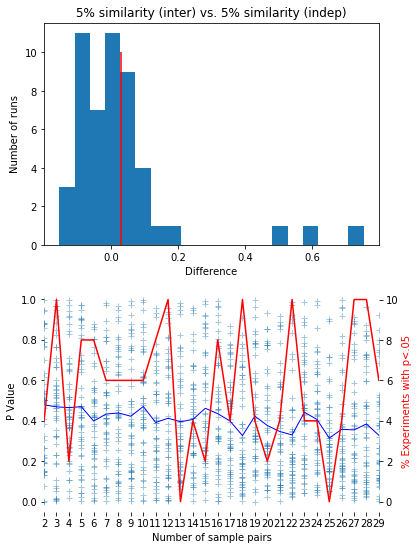

In [104]:
drawfigs(runs5, measures=['5% similarity (inter)', '5% similarity (indep)'])

## 3. smaller experiment (12 players), + remove second core

45

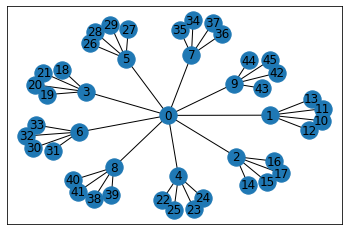

In [11]:
num_rim_nodes = 9 # needs to be odd
core_edges = [(0, i) for i in range(1, num_rim_nodes+1)]

i = num_rim_nodes+1
control_edges = copy.deepcopy(core_edges)
for n in range (1, len(core_edges)+1):
    for s in range(int((num_rim_nodes-1)/2)):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
len(control_edges)
#nx.draw_networkx(core_network)

{0: 0.09090909090909091,
 1: 0.09090909090909091,
 2: 0.09090909090909091,
 3: 0.09090909090909091,
 4: 0.09090909090909091,
 5: 0.09090909090909091,
 6: 0.09090909090909091,
 7: 0.09090909090909091,
 8: 0.09999999999999999,
 9: 0.09999999999999999,
 10: 0.09999999999999999,
 11: 0.09999999999999999}

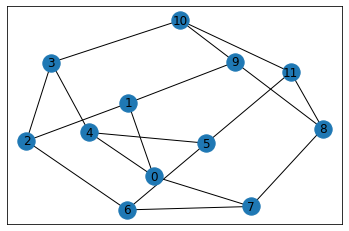

In [12]:
neighbors = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,0),
             (8,9), (9,10), (10,11), (11,8),
             (7,8), (1,9), (3,10), (5,11),
             (0,4), (2,6)]
g = nx.from_edgelist(neighbors)
nx.draw_networkx(g)
nx.betweenness_centrality(g)

In [22]:
def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step
    ts = [0]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        m.append(measure(g, beliefs))  # ignore returned init suscep and adopt
        ts.append(step+1)
        
    return pd.DataFrame(m, index=ts)  # format as pandas DataFrame

def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt

# simple adjustment
def measure(g, beliefs):
    """Take measurements of the state of the system"""
    
    beliefs = [(0,1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res

def run(g0, n_concepts=10, n_beliefs=4, n_steps=6):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2:
        new_edges = []
        for edge in g2.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [32]:
n_runs=150
runs7 = pd.concat([
    run(g).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

runs7.head()

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
6,0.462963,0.342593,0.800000,-0.225000,55.362490,0.120370,0.101852,0.755929,-0.250000,49.428539
6,0.342593,0.138889,1.000000,-0.188982,53.644804,0.120370,0.092593,1.000000,-0.188982,54.661537
6,0.453704,0.324074,0.624769,-0.395285,40.740696,0.222222,0.194444,0.661438,-0.316228,35.529502
6,0.333333,0.175926,0.932288,-0.310125,43.507290,0.138889,0.111111,0.881503,-0.251858,38.648671
6,0.472222,0.277778,1.000000,-0.395285,71.295246,0.148148,0.129630,0.816947,-0.250000,43.366493


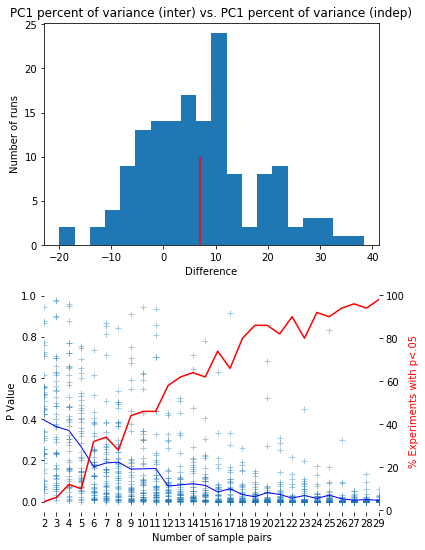

In [71]:
drawfigs(runs7)

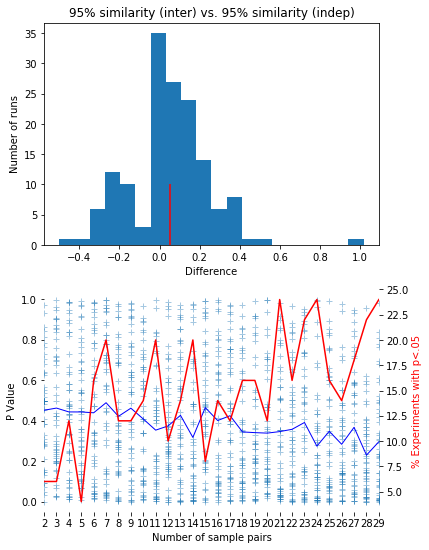

In [72]:
drawfigs(runs7, measures=['95% similarity (inter)', '95% similarity (indep)'])

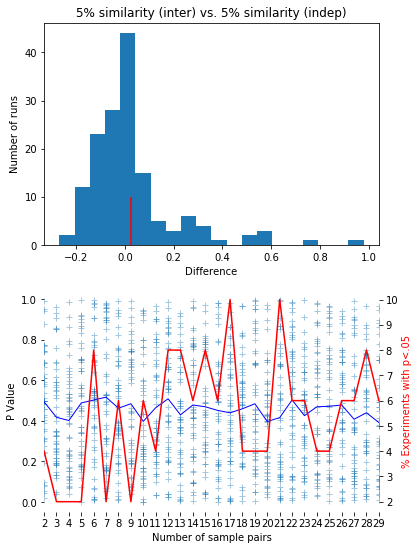

In [73]:
drawfigs(runs7, measures=['5% similarity (inter)', '5% similarity (indep)'])

## 4. Focus on the spokes/spurs

If we told the participants in advance who the suspects were, etc. We could just look at the diffusion of the outer crosslink/spur clues. We'd have more of them, and might get away from some of the messiness around the inner elements. 

The problem with this is that the argument for using the central clues is that we can see the difference in diffusion of the *same* clues from the same starting location. 

## 5. Single core, large experiment

problem with this is that we loose spoke elements, but we don't gain much in terms of number of rim elements. Nothing seems to fit with the nice number of clues per agent. 

91

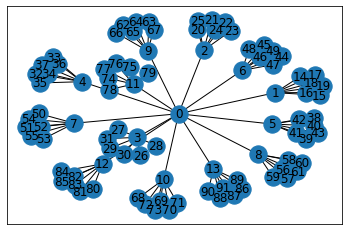

In [112]:
num_rim_nodes = 13 # needs to be odd
core_edges = [(0, i) for i in range(1, num_rim_nodes+1)]

i = num_rim_nodes+1
control_edges = copy.deepcopy(core_edges)
for n in range (1, len(core_edges)+1):
    for s in range(int((num_rim_nodes-1)/2)):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
len(control_edges)


## 6. Different measures for within group, across group similarity
The 5th percentile and 95th percentile cutoffs are arbitrary, and used in the simulation because they are easy to interpret. But fixed thresholds may not be optimal in the experiment, if the whole distribution of similarities is different between the treatment and control cases. (This could happen because of the total number of beliefs adopted.) If one distribution buts up against 1 or 0, it may also have artificially reduced variance. 
We could use a spread measure, like variance in intersubjective similarity, or STD over the difference from the mean to an extrema, to account for bounded data.


## 7. Compare to expected levels for a given level of adoption. 

What if we compared the realized result with what we should expect to see by chance with the same number of beliefs adopted. In the treatment case we should expect to see a larger increase over the random baseline than in the control case. This might be an ok comparison, if what we get by chance takes out network structure effects and any interdependence that we're not able to get out of the control case.

It's not quite as clean a case as a straight comparison between the two. Simulate and see if it gets more power. 

In [ ]:
core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

i = 13
control_edges = copy.deepcopy(core_edges)
for n in range (2, 13):
    for s in range(5):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
#nx.draw_networkx(control_beliefs)
nx.draw_networkx(core_network)


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step

    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

    # measure at end
    m.append(measure(g, beliefs))

    return pd.DataFrame(m)  # format as pandas DataFrame

def measure(g, beliefs):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
               (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100
    
    # need to repeat and take averages, or we're just comparing to a different noisy signal
    e95 = []
    e5 = []
    ePC1 = []
    for _ in range(100):
        shuffle_adopt = pd.DataFrame()
        for col in adopt.columns:
            shuffle_adopt[col] = np.random.permutation(adopt[col].values)

        n_agents = len(shuffle_adopt.index)
        corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        e95.append(np.percentile(corrs, 95))
        e5.append(np.percentile(corrs, 5))

        pca = PCA(n_components=1)
        pca.fit(shuffle_adopt)
        ePC1.append(pca.explained_variance_ratio_[0] * 100)
        
    res['expected PC1 percent of variance'] = np.mean(ePC1)
    res['expected 95% similarity'] = np.mean(e95)
    res['expected 5% similarity'] = np.mean(e5)
        
    return res


def run(g0, n_concepts=25, n_beliefs=25, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2:
        new_edges = []
        for edge in g2.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame




n_runs=250
runs8 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=4,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T


runs8.dropna(inplace=True)
n_runs=len(runs8)

runs8.head()

In [ ]:
runs8['net PC1 (inter)'] = runs8['PC1 percent of variance (inter)'] - runs8['expected PC1 percent of variance (inter)']
runs8['net PC1 (indep)'] = runs8['PC1 percent of variance (indep)'] - runs8['expected PC1 percent of variance (indep)']

runs8['net 95% sim (inter)'] = runs8['95% similarity (inter)'] - runs8['expected 95% similarity (inter)']
runs8['net 95% sim (indep)'] = runs8['95% similarity (indep)'] - runs8['expected 95% similarity (indep)']
runs8['net 5% sim (inter)'] = runs8['5% similarity (inter)'] - runs8['expected 5% similarity (inter)']
runs8['net 5% sim (indep)'] = runs8['5% similarity (indep)'] - runs8['expected 5% similarity (indep)']
runs8.head()

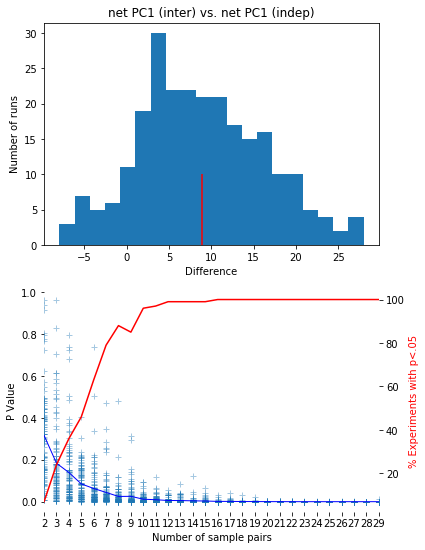

In [148]:
drawfigs(runs8, measures=['net PC1 (inter)', 'net PC1 (indep)'])

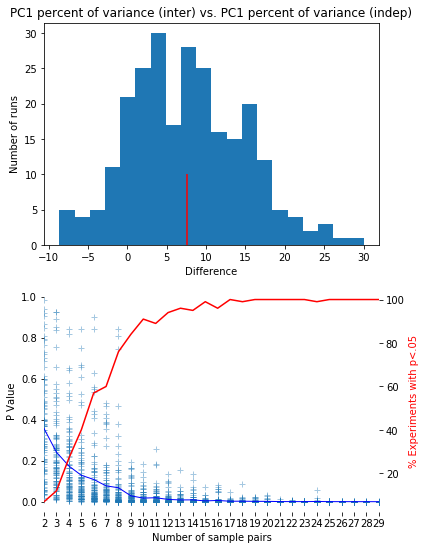

In [149]:
drawfigs(runs8)

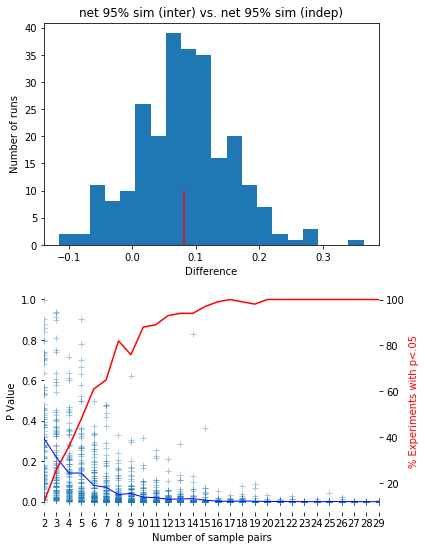

In [150]:
drawfigs(runs8, measures=['net 95% sim (inter)', 'net 95% sim (indep)'])

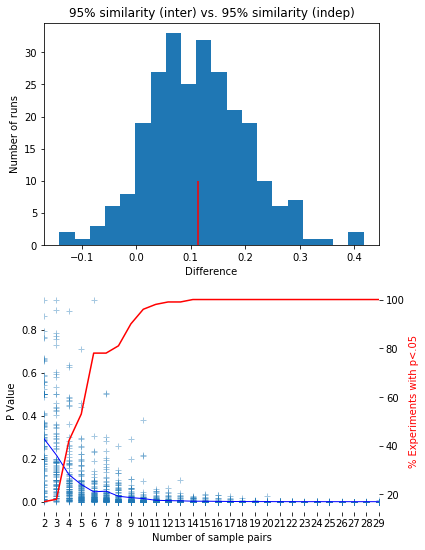

In [151]:
drawfigs(runs8, measures=['95% similarity (inter)', '95% similarity (indep)'])

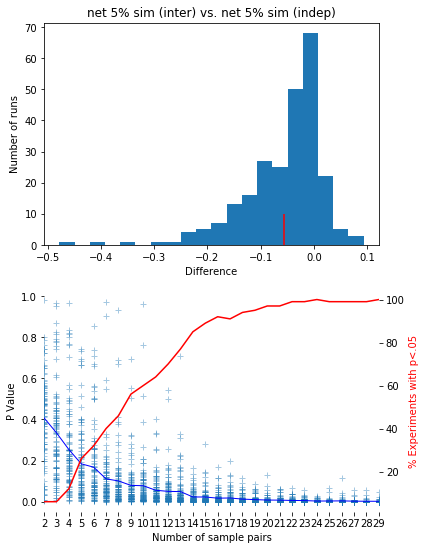

In [152]:
drawfigs(runs8, measures=['net 5% sim (inter)', 'net 5% sim (indep)'])

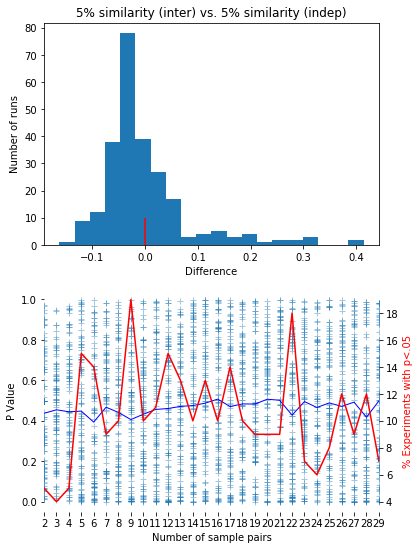

In [153]:
drawfigs(runs8, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [ ]:
! say "calculation complete"